In [1]:
import numpy as np
from jax import jit, vmap, debug
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import os,sys,re
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from itertools import cycle, islice
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'image.cmap':'jet'}
plt.rcParams.update(params)
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
from tqdm import tqdm
from EmuLP import Analysis, Template, Extinction, Galaxy, Filter

from collections import namedtuple
from functools import partial

2023-12-21 16:35:04.769797: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
summary_props = pd.read_pickle('FORS2_spectra_classif_properties_bothExt.pkl')
df_sl_spec = pd.read_pickle('FORS2-SL_spectra_for_templates_bothExt.pkl')

In [3]:
df_sl_spec.columns

Index(['Wavelength', 'SPEC_2_HZ4_BC_EBV0_Z0', 'SPEC_2_HZ4_BC_EBV0.067_Z0',
       'SPEC_2_HZ4_BC_EBV0.067_Z0.346', 'SPEC_3_HZ4_BC_EBV0_Z0',
       'SPEC_3_HZ4_BC_EBV0.076_Z0', 'SPEC_3_HZ4_BC_EBV0.076_Z0.687',
       'SPEC_9_HZ4_BC_EBV0_Z0', 'SPEC_9_HZ4_BC_EBV0.019_Z0',
       'SPEC_9_HZ4_BC_EBV0.019_Z0.293',
       ...
       'SPEC_735_HZ4_BC_EBV0.091_Z0.362', 'SPEC_736_HZ4_BC_EBV0_Z0',
       'SPEC_736_HZ4_BC_EBV0.201_Z0', 'SPEC_736_HZ4_BC_EBV0.201_Z0.558',
       'SPEC_737_HZ4_BC_EBV0_Z0', 'SPEC_737_HZ4_BC_EBV0.002_Z0',
       'SPEC_737_HZ4_BC_EBV0.002_Z0.520', 'SPEC_738_HZ4_BC_EBV0_Z0',
       'SPEC_738_HZ4_BC_EBV0.001_Z0', 'SPEC_738_HZ4_BC_EBV0.001_Z0.560'],
      dtype='object', length=1651)

In [4]:
summary_props

,FORS2-SL Id,RA[deg],DEC[deg],Redshift,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),...,M(hsc_iHSC)_z0_e0,M(hsc_zHSC)_z0_e0,M(hsc_yHSC)_z0_e0,Ext law,E(B-V),D4000n,NUVK,Type,Tag,Lines
0,2,13.52997,-28.44776,0.34555,25.656134,25.745916,24.930092,23.645802,22.995878,22.639219,...,9.576632,9.346443,9.088726,Calzetti,0.067182,0.731663,4.599056,E/S0,"SPEC2 , z=0.35, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
1,3,13.52552,-28.42080,0.68660,27.445406,27.456282,26.886576,25.794489,24.913620,24.694273,...,10.212948,10.127766,10.059660,Calzetti,0.076149,0.823350,3.359125,Sbc,"SPEC3 , z=0.69, lines=[OII],H9,K,H,H{beta},[OI...","b'[OII],H9,K,H,H{beta},[OIII],H8 ..."
2,9,13.50219,-28.40641,0.29266,25.645470,25.895012,24.405609,23.158213,22.570601,22.300610,...,9.830420,9.640383,9.454109,Calzetti,0.018776,0.643971,5.126751,E/S0,"SPEC9 , z=0.29, lines=H9,H8,K,H","b'H9,H8,K,H ..."
3,13,13.49261,-28.38272,0.68870,26.768324,26.846340,26.402250,26.112743,25.853102,25.812508,...,11.298798,11.133028,10.969179,Prevot,0.225470,1.034968,1.991021,Scd,"SPEC13 , z=0.69, lines=[OII],H{epsilon},H{delt...","b'[OII],H{epsilon},H{delta},H{beta} ..."
4,19,13.60758,-28.43452,0.48395,26.597130,26.724215,25.864109,24.474184,23.785151,23.457129,...,9.368839,9.169516,8.937725,Prevot,0.199623,0.806435,5.076760,E/S0,"SPEC19 , z=0.48, lines=H10,H9,H8,K,H,H{delta}","b'H10,H9,H8,K,H,H{delta} ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,734,13.68083,-28.23290,0.23012,21.852413,21.929195,21.131676,20.339006,19.937302,19.692709,...,7.437572,7.284735,7.114416,Prevot,0.224031,0.856026,3.635435,Sbc,"SPEC734 , z=0.23, lines=[OII],H9,K,H,H{alpha},NII","b'[OII],H9,K,H,H{alpha},NII ..."
546,735,13.69958,-28.23161,0.36169,23.979353,24.611977,22.326378,20.769735,20.153635,19.881050,...,6.829590,6.670799,6.471434,Prevot,0.091018,0.634273,7.225021,E/S0,"SPEC735 , z=0.36, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
547,736,13.66431,-28.22849,0.55777,26.097153,26.168510,25.715277,25.054239,24.657543,24.507502,...,10.399363,10.336321,10.274342,Prevot,0.201171,0.957919,2.254125,Scd,"SPEC736 , z=0.56, lines=[OII],H9,H{beta},[OIII]","b'[OII],H9,H{beta},[OIII] ..."
548,737,13.62722,-28.22692,0.52001,25.801903,25.909632,25.059542,23.921055,23.381739,23.152592,...,9.593592,9.502151,9.444016,Calzetti,0.001769,0.785689,2.974097,Scd,"SPEC737 , z=0.52, lines=[OII],K,H","b'[OII],K,H ..."


In [5]:
_sel = np.logical_and(summary_props['E(B-V)']<0.6, summary_props['Redshift']<1.6)
restricted_df = summary_props[_sel]
counts, edges = np.histogram(restricted_df['E(B-V)'].values, bins='auto')
edges

array([2.29337051e-14, 4.13981613e-02, 8.27963226e-02, 1.24194484e-01,
       1.65592645e-01, 2.06990806e-01, 2.48388968e-01, 2.89787129e-01,
       3.31185290e-01, 3.72583452e-01, 4.13981613e-01, 4.55379774e-01,
       4.96777936e-01, 5.38176097e-01])

In [6]:
def avg_normed_spec(gal_type, ebv_low, ebv_high, ext_law="Calzetti"):
    _sel = np.logical_and(np.logical_and(np.logical_and(summary_props['E(B-V)']>ebv_low,\
                                                        summary_props['E(B-V)']<=ebv_high),\
                                         summary_props['Type']==gal_type),\
                          summary_props['Ext law']==ext_law)
    if np.any(_sel):
        print(f"Type: {gal_type}, {ext_law} dust extinction, avg E(B-V): {0.5*(e_inf+e_sup):.3f} - {len(_sel[_sel])} spectra")
        nums = summary_props[_sel]['FORS2-SL Id'].values
        ebvs = summary_props[_sel]['E(B-V)'].values
        wls = df_sl_spec['Wavelength'].values
        _nsel = np.logical_and(wls>1000., wls<10000.)
        specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV{ebv:.3f}_Z0'].values for (n,ebv) in zip(nums, ebvs))
        specs = np.column_stack(specs_to_stack)
        norms = np.trapz(specs[_nsel], x=wls[_nsel], axis=0)
        specsN_to_stack = tuple(specs[:,j]/norms[j] for j in range(len(norms)))
        normed_specs = jnp.column_stack(specsN_to_stack)
        avg_spec = np.mean(normed_specs, axis=1)
        dev_spec = np.std(normed_specs, axis=1)
    else:
        avg_spec, dev_spec = None, None
    return avg_spec, dev_spec

def avg_spec(gal_type, ebv_low, ebv_high, ext_law="Calzetti"):
    _sel = np.logical_and(np.logical_and(np.logical_and(summary_props['E(B-V)']>ebv_low,\
                                                        summary_props['E(B-V)']<=ebv_high),\
                                         summary_props['Type']==gal_type),\
                          summary_props['Ext law']==ext_law)
    if np.any(_sel):
        print(f"Type: {gal_type}, {ext_law} dust extinction, avg E(B-V): {0.5*(e_inf+e_sup):.3f} - {len(_sel[_sel])} spectra")
        nums = summary_props[_sel]['FORS2-SL Id'].values
        ebvs = summary_props[_sel]['E(B-V)'].values
        wls = df_sl_spec['Wavelength'].values
        specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV{ebv:.3f}_Z0'].values for (n,ebv) in zip(nums, ebvs))
        specs = np.column_stack(specs_to_stack)
        avg_spec = np.mean(specs, axis=1)
        dev_spec = np.std(specs, axis=1)
    else:
        avg_spec, dev_spec = None, None
    return avg_spec, dev_spec

def avg_spec_EBV0(gal_type, ebv_low, ebv_high, ext_law="Calzetti"):
    _sel = np.logical_and(np.logical_and(np.logical_and(summary_props['E(B-V)']>ebv_low,\
                                                        summary_props['E(B-V)']<=ebv_high),\
                                         summary_props['Type']==gal_type),\
                          summary_props['Ext law']==ext_law)
    if np.any(_sel):
        print(f"Type: {gal_type}, {ext_law} dust extinction, avg E(B-V): {0.5*(e_inf+e_sup):.3f} - {len(_sel[_sel])} spectra")
        nums = summary_props[_sel]['FORS2-SL Id'].values
        ebvs = summary_props[_sel]['E(B-V)'].values
        wls = df_sl_spec['Wavelength'].values
        specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV0_Z0'].values for n in nums)
        specs = np.column_stack(specs_to_stack)
        avg_spec = np.mean(specs, axis=1)
        dev_spec = np.std(specs, axis=1)
    else:
        avg_spec, dev_spec = None, None
    return avg_spec, dev_spec

In [7]:
df_dusty_templates = pd.DataFrame()
df_dusty_templates['Wavelength'] = df_sl_spec['Wavelength'].values
for galtyp in np.unique(summary_props['Type'].values):
    for ext_law in np.unique(summary_props['Ext law'].values):
        for e_inf, e_sup in zip(edges[:-1], edges[1:]):
            avg_typ_ebv, sig_typ_ebv = avg_spec(galtyp, e_inf, e_sup, ext_law)
            if avg_typ_ebv is not None:
                df_dusty_templates[f'AVG_{galtyp}_{ext_law}_EBV{0.5*(e_inf+e_sup):.3f}'] = avg_typ_ebv
        
df_dusty_templates

Type: E/S0, Calzetti dust extinction, avg E(B-V): 0.021 - 46 spectra
Type: E/S0, Calzetti dust extinction, avg E(B-V): 0.062 - 50 spectra
Type: E/S0, Calzetti dust extinction, avg E(B-V): 0.103 - 2 spectra
Type: E/S0, Calzetti dust extinction, avg E(B-V): 0.228 - 1 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.021 - 17 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.062 - 10 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.103 - 11 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.145 - 7 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.186 - 11 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.228 - 27 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.269 - 15 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.310 - 4 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.352 - 2 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.393 - 1 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.435 - 1 sp

,Wavelength,AVG_E/S0_Calzetti_EBV0.021,AVG_E/S0_Calzetti_EBV0.062,AVG_E/S0_Calzetti_EBV0.103,AVG_E/S0_Calzetti_EBV0.228,AVG_E/S0_Prevot_EBV0.021,AVG_E/S0_Prevot_EBV0.062,AVG_E/S0_Prevot_EBV0.103,AVG_E/S0_Prevot_EBV0.145,AVG_E/S0_Prevot_EBV0.186,...,AVG_Scd_Calzetti_EBV0.062,AVG_Scd_Calzetti_EBV0.103,AVG_Scd_Calzetti_EBV0.228,AVG_Scd_Prevot_EBV0.021,AVG_Scd_Prevot_EBV0.062,AVG_Scd_Prevot_EBV0.103,AVG_Scd_Prevot_EBV0.145,AVG_Scd_Prevot_EBV0.186,AVG_Scd_Prevot_EBV0.228,AVG_Scd_Prevot_EBV0.269
0,1.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
1,2.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
2,3.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
3,4.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
4,5.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996.0,0.013494,1.694809e-02,2.136196e-02,2.490232e-03,0.031074,0.010006,0.017639,0.008236,0.011011,...,5.965513e-03,1.358607e-02,3.795468e-03,0.003171,0.002272,0.003108,0.002975,0.001759,0.003464,0.001718
24996,24997.0,0.013496,1.694983e-02,2.136416e-02,2.490518e-03,0.031078,0.010007,0.017641,0.008236,0.011012,...,5.966169e-03,1.358794e-02,3.795896e-03,0.003172,0.002272,0.003108,0.002976,0.001759,0.003464,0.001718
24997,24998.0,0.013497,1.695157e-02,2.136635e-02,2.490804e-03,0.031081,0.010008,0.017642,0.008237,0.011013,...,5.966825e-03,1.358981e-02,3.796324e-03,0.003172,0.002272,0.003108,0.002976,0.001759,0.003465,0.001718
24998,24999.0,0.013499,1.695331e-02,2.136854e-02,2.491089e-03,0.031084,0.010009,0.017644,0.008238,0.011014,...,5.967482e-03,1.359169e-02,3.796752e-03,0.003172,0.002272,0.003109,0.002976,0.001759,0.003465,0.001719


In [8]:
df_EBV0_templates = pd.DataFrame()
df_EBV0_templates['Wavelength'] = df_sl_spec['Wavelength'].values
for galtyp in np.unique(summary_props['Type'].values):
    for ext_law in np.unique(summary_props['Ext law'].values):
        for e_inf, e_sup in zip(edges[:-1], edges[1:]):
            avg_typ_ebv, sig_typ_ebv = avg_spec_EBV0(galtyp, e_inf, e_sup, ext_law)
            if avg_typ_ebv is not None:
                df_EBV0_templates[f'AVG_{galtyp}_{ext_law}_EBV{0.5*(e_inf+e_sup):.3f}'] = avg_typ_ebv
        
df_EBV0_templates

Type: E/S0, Calzetti dust extinction, avg E(B-V): 0.021 - 46 spectra
Type: E/S0, Calzetti dust extinction, avg E(B-V): 0.062 - 50 spectra
Type: E/S0, Calzetti dust extinction, avg E(B-V): 0.103 - 2 spectra
Type: E/S0, Calzetti dust extinction, avg E(B-V): 0.228 - 1 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.021 - 17 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.062 - 10 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.103 - 11 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.145 - 7 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.186 - 11 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.228 - 27 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.269 - 15 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.310 - 4 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.352 - 2 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.393 - 1 spectra
Type: E/S0, Prevot dust extinction, avg E(B-V): 0.435 - 1 sp

,Wavelength,AVG_E/S0_Calzetti_EBV0.021,AVG_E/S0_Calzetti_EBV0.062,AVG_E/S0_Calzetti_EBV0.103,AVG_E/S0_Calzetti_EBV0.228,AVG_E/S0_Prevot_EBV0.021,AVG_E/S0_Prevot_EBV0.062,AVG_E/S0_Prevot_EBV0.103,AVG_E/S0_Prevot_EBV0.145,AVG_E/S0_Prevot_EBV0.186,...,AVG_Scd_Calzetti_EBV0.062,AVG_Scd_Calzetti_EBV0.103,AVG_Scd_Calzetti_EBV0.228,AVG_Scd_Prevot_EBV0.021,AVG_Scd_Prevot_EBV0.062,AVG_Scd_Prevot_EBV0.103,AVG_Scd_Prevot_EBV0.145,AVG_Scd_Prevot_EBV0.186,AVG_Scd_Prevot_EBV0.228,AVG_Scd_Prevot_EBV0.269
0,1.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
1,2.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
2,3.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
3,4.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
4,5.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996.0,0.013525,0.017167,0.021741,0.002598,0.031141,0.010097,0.017925,0.008445,0.011380,...,0.006044,0.013817,0.003950,0.003172,0.002301,0.003168,0.003052,0.001817,0.003599,0.001798
24996,24997.0,0.013526,0.017169,0.021743,0.002598,0.031145,0.010098,0.017926,0.008446,0.011381,...,0.006045,0.013819,0.003951,0.003173,0.002302,0.003169,0.003052,0.001817,0.003600,0.001798
24997,24998.0,0.013528,0.017170,0.021745,0.002599,0.031148,0.010099,0.017928,0.008447,0.011383,...,0.006045,0.013821,0.003951,0.003173,0.002302,0.003169,0.003052,0.001817,0.003600,0.001798
24998,24999.0,0.013529,0.017172,0.021747,0.002599,0.031151,0.010100,0.017930,0.008448,0.011384,...,0.006046,0.013823,0.003951,0.003173,0.002302,0.003169,0.003053,0.001818,0.003601,0.001799


## Load DSPS spectra

In [9]:
import h5py

In [10]:
input_dir = "/sps/lsst/groups/photoz/sylvie2024/SSP-DSPS"
input_dir = "."
h5_file_name = "FittedSSPspectra.hdf5"
input_file_h5 = os.path.abspath(os.path.join(input_dir, h5_file_name))

In [11]:
if os.path.isfile(input_file_h5):
    hf = h5py.File(input_file_h5, 'r')
    list_of_groupkeys = list(hf.keys())
    
    # pick one key
    key_sel =  list_of_groupkeys[0]
    
    # pick one group
    group = hf.get(key_sel)
    
    #pickup all attribute names
    list_of_subgroup_keys = []
    for k in group.attrs.keys():
        list_of_subgroup_keys.append(k)
else:
    hf = None
    list_of_groupkeys = []
    list_of_subgroup_keys = []
    
[int(s.split('C')[-1]) for s in list_of_groupkeys[:10]]

[102, 106, 107, 109, 113, 114, 115, 117, 118, 120]

In [12]:
list_of_subgroup_keys

['AV',
 'MAH_early_index',
 'MAH_late_index',
 'MAH_lgmO',
 'MAH_logtc',
 'MS_indx_hi',
 'MS_indx_lo',
 'MS_lgmcrit',
 'MS_lgy_at_mcrit',
 'MS_tau_dep',
 'Nc',
 'Nm',
 'Ns',
 'PLAW_SLOPE',
 'Q_lg_drop',
 'Q_lg_qt',
 'Q_lg_rejuv',
 'Q_qlglgdt',
 'SCALEF',
 'UV_BUMP',
 'fors2name',
 'funcmin_c',
 'funcmin_m',
 'funcmin_s',
 'zobs']

In [13]:
groupname = list_of_groupkeys[0]
group = hf.get(groupname)
wl = np.array(group.get("wl"))
fl = np.array(group.get("fl"))
fl_dust = np.array(group.get("fl_dust"))
fnu = np.array(group.get("fnu"))
z = group.attrs.get("zobs")
spec_id = int(groupname.split('C')[-1])

print(z, spec_id)

0.5133 102


In [14]:
df_sl_spec

,Wavelength,SPEC_2_HZ4_BC_EBV0_Z0,SPEC_2_HZ4_BC_EBV0.067_Z0,SPEC_2_HZ4_BC_EBV0.067_Z0.346,SPEC_3_HZ4_BC_EBV0_Z0,SPEC_3_HZ4_BC_EBV0.076_Z0,SPEC_3_HZ4_BC_EBV0.076_Z0.687,SPEC_9_HZ4_BC_EBV0_Z0,SPEC_9_HZ4_BC_EBV0.019_Z0,SPEC_9_HZ4_BC_EBV0.019_Z0.293,...,SPEC_735_HZ4_BC_EBV0.091_Z0.362,SPEC_736_HZ4_BC_EBV0_Z0,SPEC_736_HZ4_BC_EBV0.201_Z0,SPEC_736_HZ4_BC_EBV0.201_Z0.558,SPEC_737_HZ4_BC_EBV0_Z0,SPEC_737_HZ4_BC_EBV0.002_Z0,SPEC_737_HZ4_BC_EBV0.002_Z0.520,SPEC_738_HZ4_BC_EBV0_Z0,SPEC_738_HZ4_BC_EBV0.001_Z0,SPEC_738_HZ4_BC_EBV0.001_Z0.560
0,1.0,0.000002,1.377886e-09,0.000000e+00,0.000286,6.319051e-08,0.000000e+00,0.000044,0.000006,0.000000,...,0.000000,0.001572,0.001572,0.000000,0.000401,0.000329,0.000000,0.000074,0.000069,0.000000
1,2.0,0.000002,1.377886e-09,1.377886e-09,0.000286,6.319051e-08,6.319051e-08,0.000044,0.000006,0.000006,...,0.000158,0.001572,0.001572,0.001572,0.000401,0.000329,0.000329,0.000074,0.000069,0.000069
2,3.0,0.000002,1.377886e-09,1.377886e-09,0.000286,6.319051e-08,6.319051e-08,0.000044,0.000006,0.000006,...,0.000158,0.001572,0.001572,0.001572,0.000401,0.000329,0.000329,0.000074,0.000069,0.000069
3,4.0,0.000002,1.377886e-09,1.377886e-09,0.000286,6.319051e-08,6.319051e-08,0.000044,0.000006,0.000006,...,0.000158,0.001572,0.001572,0.001572,0.000401,0.000329,0.000329,0.000074,0.000069,0.000069
4,5.0,0.000002,1.377886e-09,1.377886e-09,0.000286,6.319051e-08,6.319051e-08,0.000044,0.000006,0.000006,...,0.000158,0.001572,0.001572,0.001572,0.000401,0.000329,0.000329,0.000074,0.000069,0.000069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996.0,0.004812,4.753814e-03,1.765526e-02,0.001660,1.637357e-03,8.352255e-03,0.003335,0.003324,0.010572,...,0.199953,0.001335,0.001289,0.006060,0.002938,0.002937,0.013909,0.015824,0.015822,0.087408
24996,24997.0,0.004813,4.754275e-03,1.765031e-02,0.001660,1.637505e-03,8.353758e-03,0.003336,0.003324,0.010570,...,0.199990,0.001335,0.001289,0.006059,0.002938,0.002937,0.013908,0.015826,0.015824,0.087400
24997,24998.0,0.004813,4.754736e-03,1.764536e-02,0.001660,1.637652e-03,8.355257e-03,0.003336,0.003325,0.010568,...,0.200027,0.001335,0.001289,0.006059,0.002938,0.002937,0.013907,0.015827,0.015825,0.087392
24998,24999.0,0.004814,4.755197e-03,1.764042e-02,0.001661,1.637799e-03,8.356758e-03,0.003336,0.003325,0.010567,...,0.200065,0.001335,0.001289,0.006058,0.002938,0.002937,0.013906,0.015829,0.015827,0.087384


In [15]:
def flux_norm(wl: np.array,fl: np.array,wlcenter: float = 6231.,wlwdt: float = 50.) -> float:
    """Normalize the flux at a given wavelength

    :param wl: wavelength array of the spectrum
    :type wl: np.array of floats

    :param fl: flux rray of the spectrum
    :type fl: np.array of float

    :param wlcenter: wavelength where the normalisation is done, defaults to 6231.
    :type wlcenter: float, optional

    :param wlwdt: wavelength width where the normalisation factor si calculated, defaults to 50.
    :type wlwdt: float, optional

    :return: the normalisation factor
    :rtype: float
    """
    lambda_red = wlcenter
    lambda_width = wlwdt
    lambda_sel_min = lambda_red-lambda_width /2.
    lambda_sel_max = lambda_red+lambda_width /2.

    idx_wl_sel = np.where(np.logical_and(wl>= lambda_sel_min,wl<= lambda_sel_max))[0]
    flarr_norm = fl[idx_wl_sel]
    return np.median(flarr_norm)

In [16]:
wl_sl = df_sl_spec['Wavelength'].values
fl_sl = df_sl_spec[f"SPEC_{spec_id}_HZ4_BC_EBV0_Z0"].values
norm_sl = flux_norm(wl_sl, fl_sl)

(1e-05, 100)

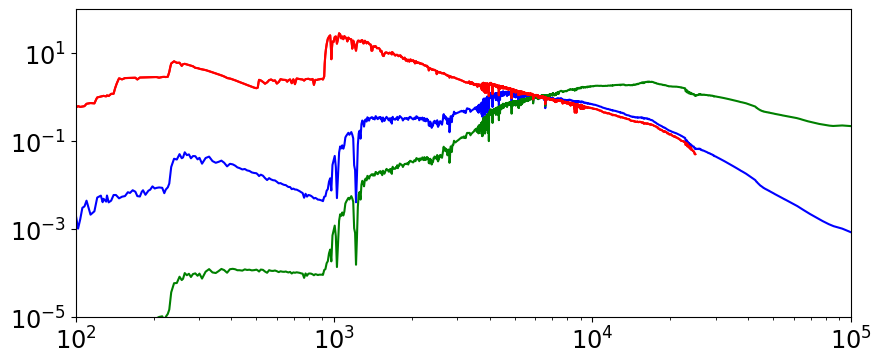

In [17]:
_, ax = plt.subplots(1, 1,figsize=(10,4))
ax.plot(wl,fl,'b-')
ax.plot(wl,fnu,'g-')
ax.plot(wl_sl, fl_sl/norm_sl, 'r-')
ax.plot(wl_sl, fl_sl/norm_sl, 'r-')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(100.,1e5)
ax.set_ylim(1e-5,100)

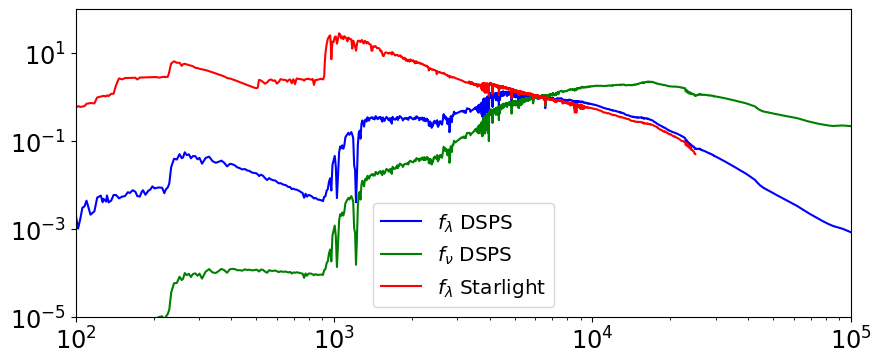

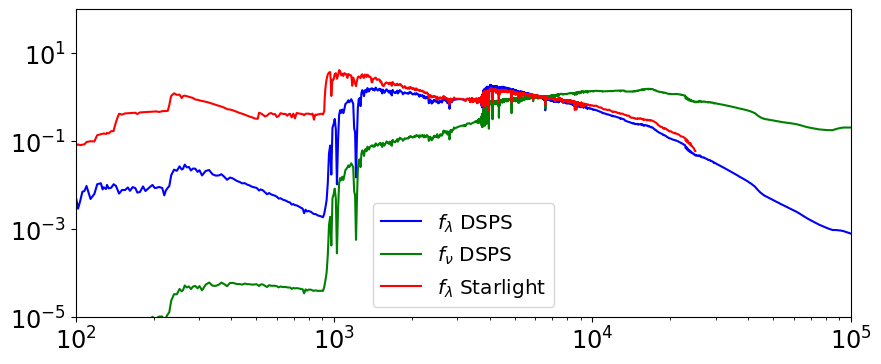

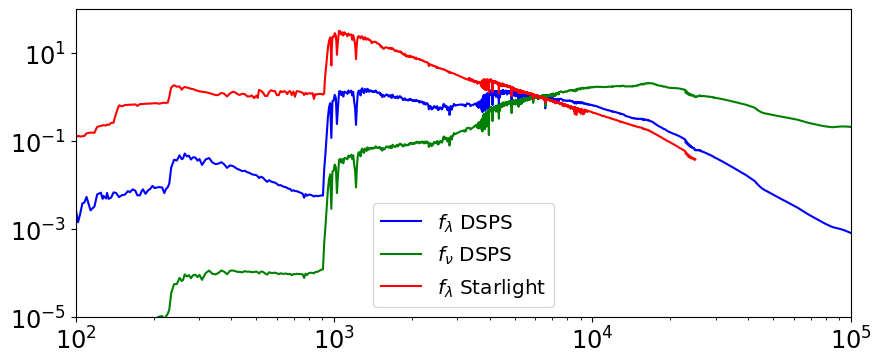

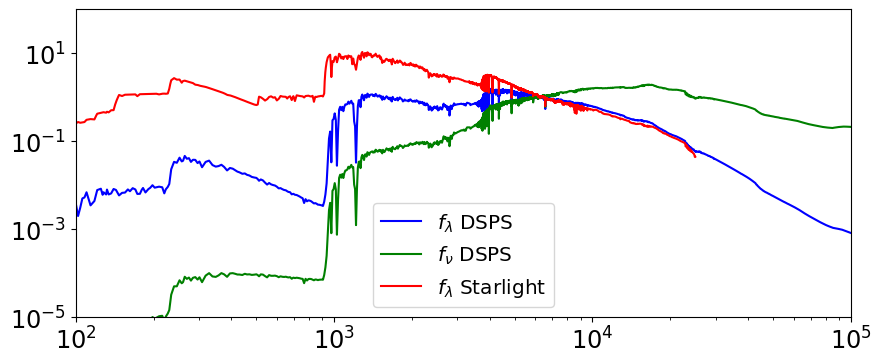

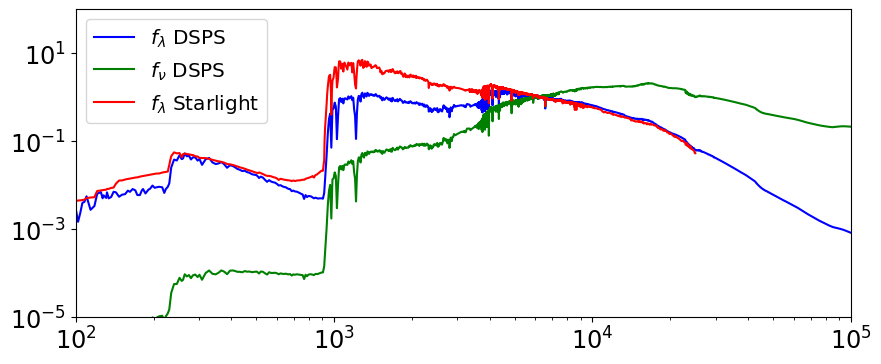

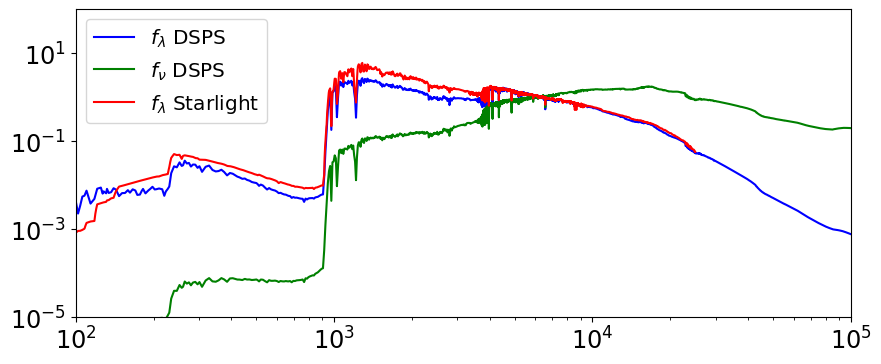

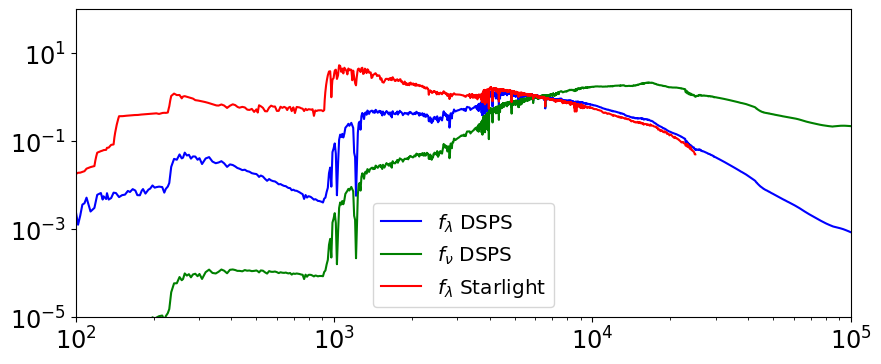

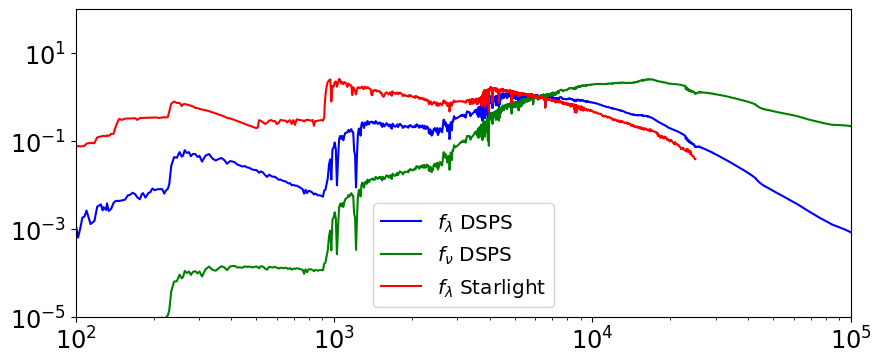

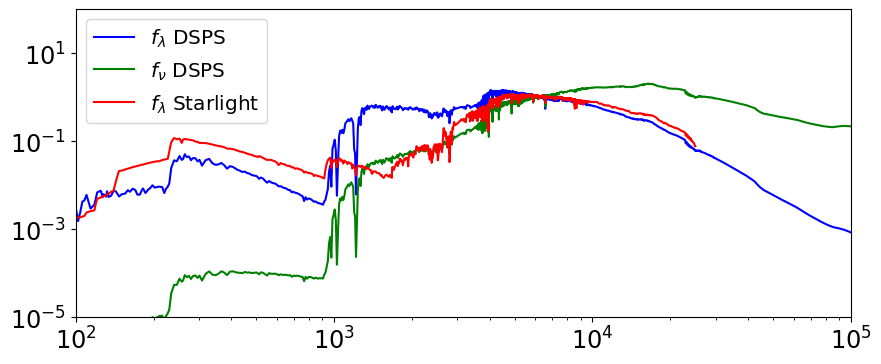

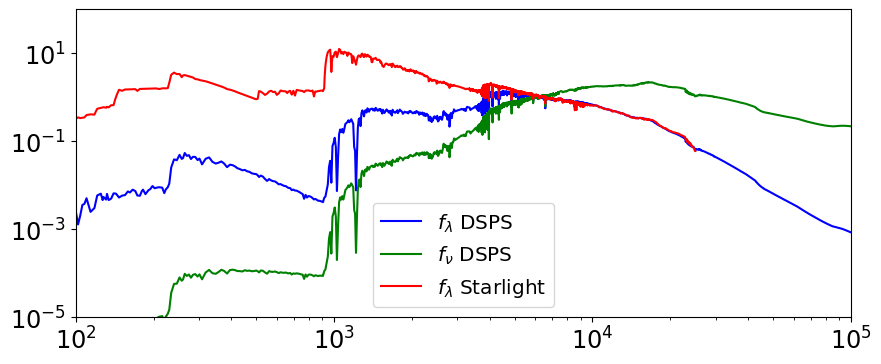

In [18]:
for groupname in list_of_groupkeys[:10]:
    group = hf.get(groupname)
    wl = np.array(group.get("wl"))
    fl = np.array(group.get("fl"))
    fnu = np.array(group.get("fnu"))
    z = group.attrs.get("zobs")
    
    spec_id = int(groupname.split('C')[-1])
    wl_sl = df_sl_spec['Wavelength'].values
    fl_sl = df_sl_spec[f"SPEC_{spec_id}_HZ4_BC_EBV0_Z0"].values
    norm_sl = flux_norm(wl_sl, fl_sl)
    
    _, ax = plt.subplots(1, 1,figsize=(10,4))
    ax.plot(wl,fl,'b-', label="$f_\lambda$ DSPS")
    ax.plot(wl,fnu,'g-', label="$f_\\nu$ DSPS")
    ax.plot(wl_sl, fl_sl/norm_sl, 'r-', label="$f_\lambda$ Starlight")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(100.,1e5)
    ax.set_ylim(1e-5,100)
    ax.legend()

## Comparer les spectres "templates" Starlight vs. DSPS

In [19]:
from EmuLP import Analysis

In [20]:
test_conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-prior-full-KinCalClusTempNoAVG_priorEBV_noTypeNoLaw.json'
cosmo_test, z_grid_test, fine_z_grid_test, wl_grid_test, filters_arr_test, named_filts_test, baseTemp_arr_test, extlaws_dict_test,\
ebv_vals_test, dust_arr_test, wls_opa_test, opa_zgrid_test, opacity_grid_test, obs_arr_test = Analysis.load_data_for_analysis(os.path.basename(test_conf_json))

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 45.46it/s]


Building templates :


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1093.55it/s]


In [21]:
inputs = Analysis.json_to_inputs(test_conf_json)
templates_dict = inputs['Templates']
templates_dict

{'0': {'name': 'CWW_Sbc-id226',
  'path': '../LEPHARE/sed/GAL/FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_Sbc_ext_id226.sed'},
 '1': {'name': 'CWW_Sbc-id227',
  'path': '../LEPHARE/sed/GAL/FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_Sbc_ext_id227.sed'},
 '2': {'name': 'CWW_Sbc-id451',
  'path': '../LEPHARE/sed/GAL/FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_Sbc_ext_id451.sed'},
 '3': {'name': 'CWW_Sbc-id714',
  'path': '../LEPHARE/sed/GAL/FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_Sbc_ext_id714.sed'},
 '4': {'name': 'CWW_Sbc-id496',
  'path': '../LEPHARE/sed/GAL/FORS2_KinCalClus_batch6/EXT1_CLUST_CWW_Sbc_ext_id496.sed'},
 '5': {'name': 'CWW_Sbc-id589',
  'path': '../LEPHARE/sed/GAL/FORS2_KinCalClus_batch6/EXT2_CLUST_CWW_Sbc_ext_id589.sed'},
 '6': {'name': 'CWW_E-id282',
  'path': '../LEPHARE/sed/GAL/FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_E_ext_id282.sed'},
 '7': {'name': 'CWW_E-id235',
  'path': '../LEPHARE/sed/GAL/FORS2_KinCalClus_batch6/EXT1_CLUST_CWW_E_ext_id235.sed'},
 '8': {'name': 'CWW_E-id304

In [22]:
id_temp_fors2 = [int(templates_dict[t]['name'].split('id')[-1]) for t in templates_dict]
id_temp_fors2

[226,
 227,
 451,
 714,
 496,
 589,
 282,
 235,
 304,
 87,
 107,
 113,
 114,
 265,
 537,
 546,
 344,
 699,
 45,
 268,
 291,
 354,
 639,
 532,
 585]

304


/tmp/ipykernel_2154/3317560117.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1,figsize=(10,4))


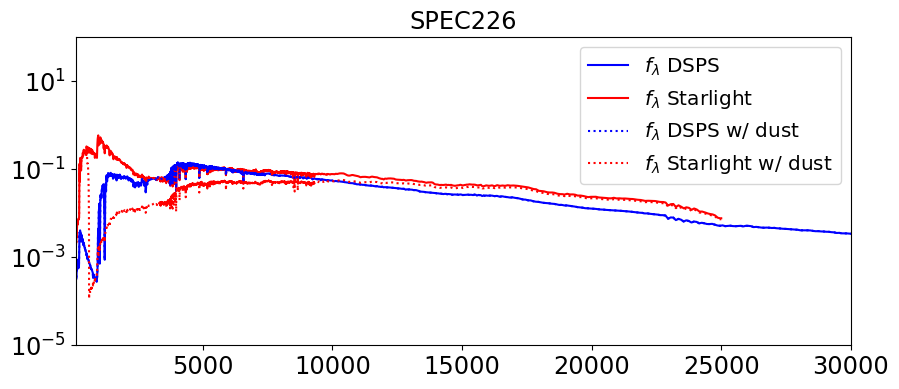

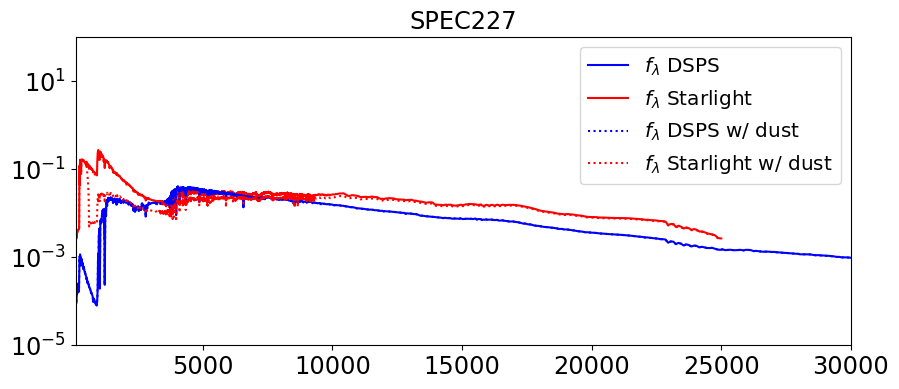

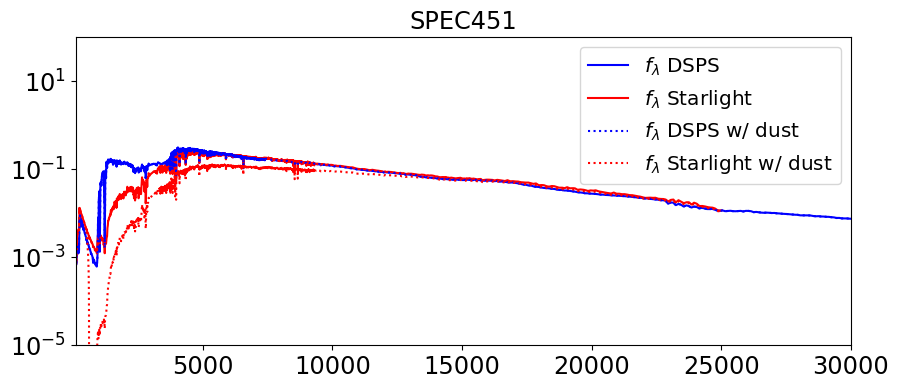

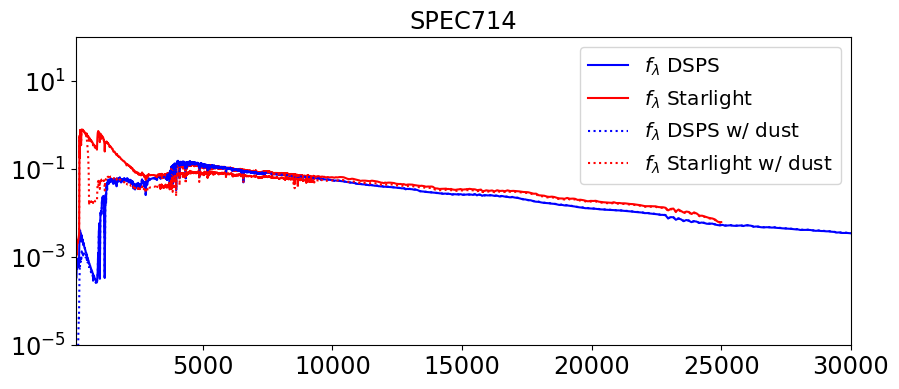

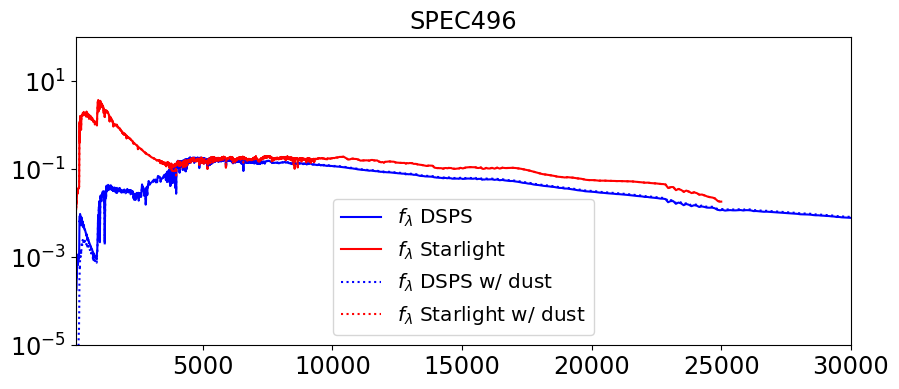

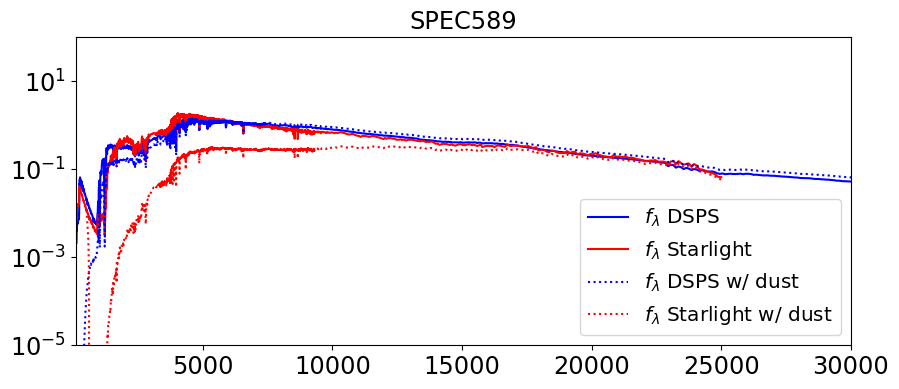

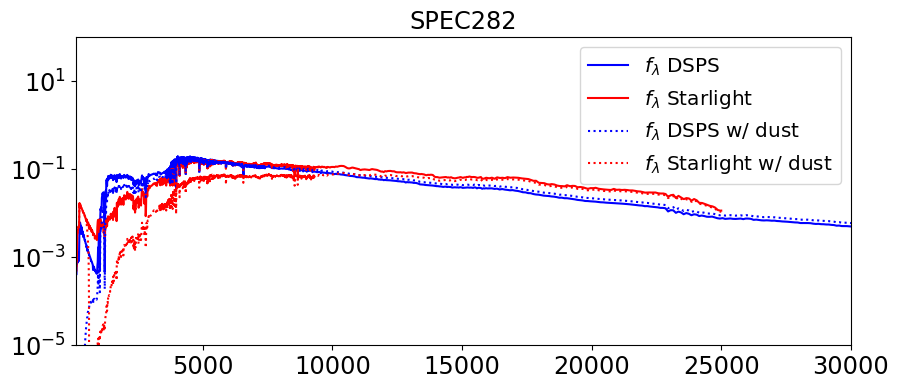

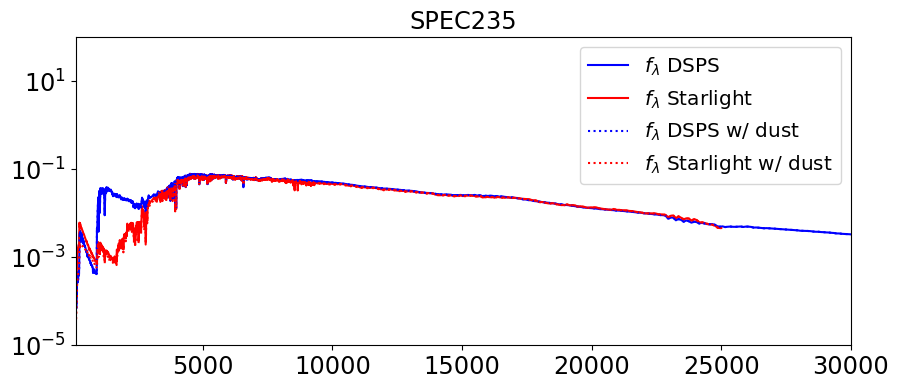

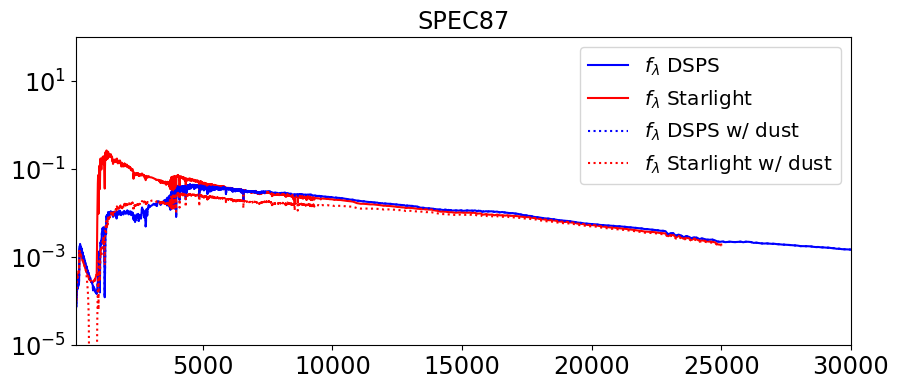

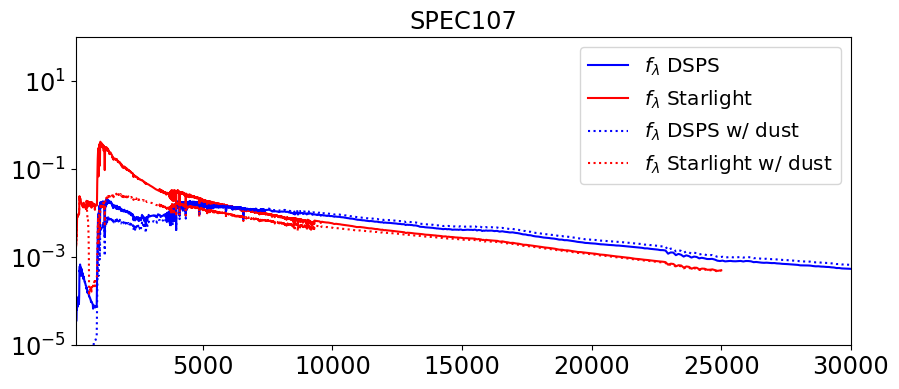

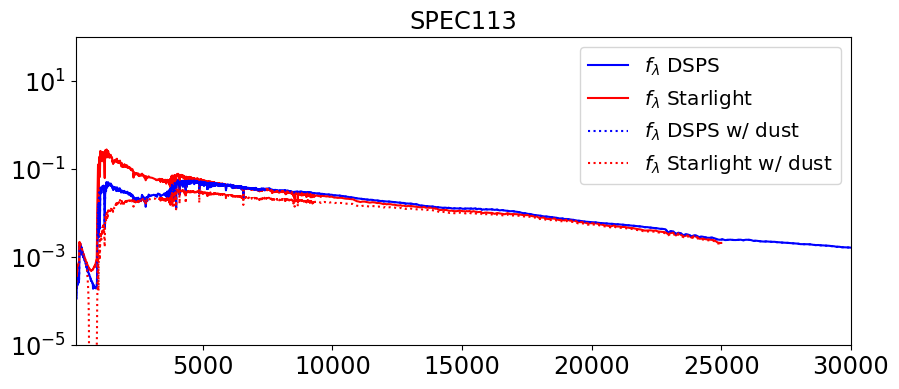

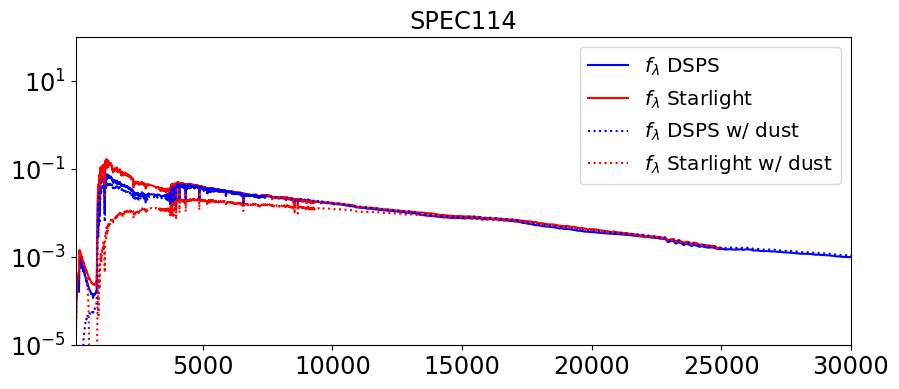

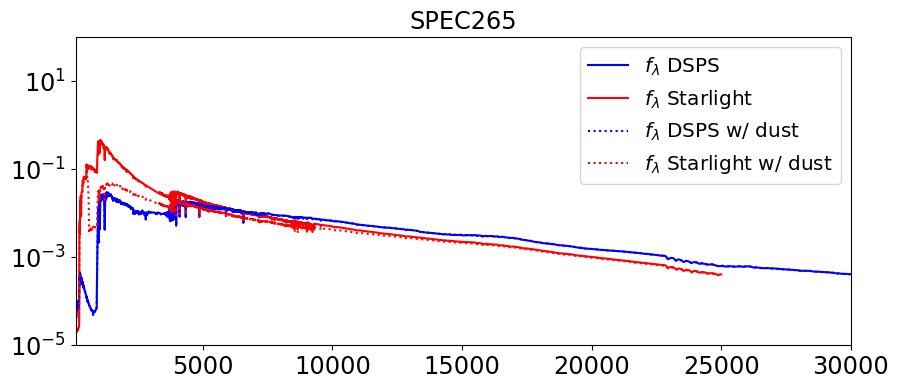

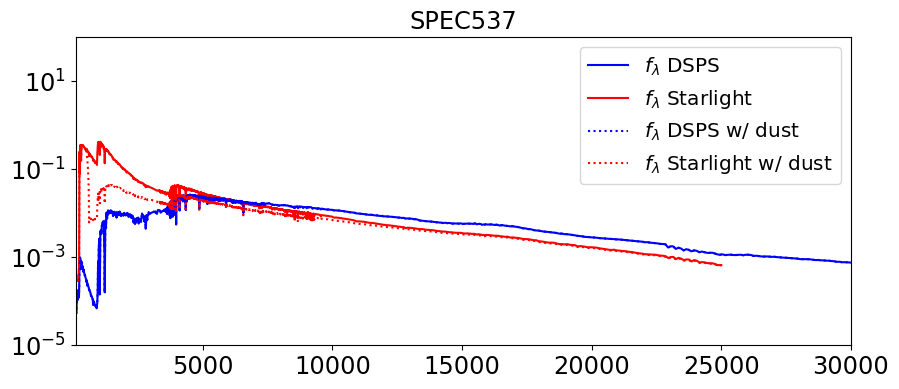

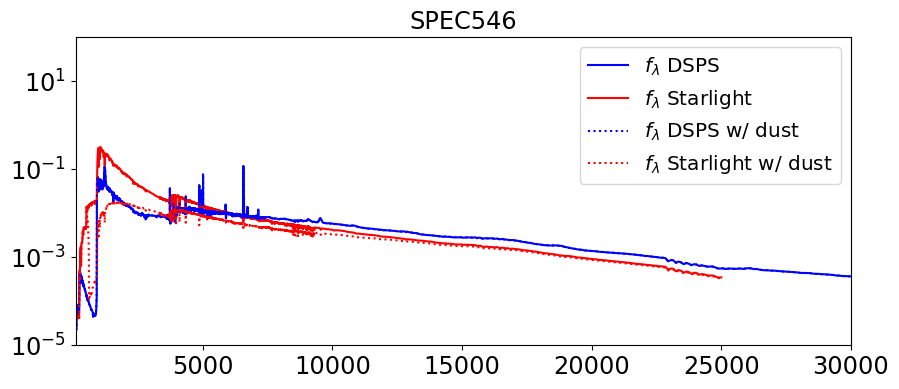

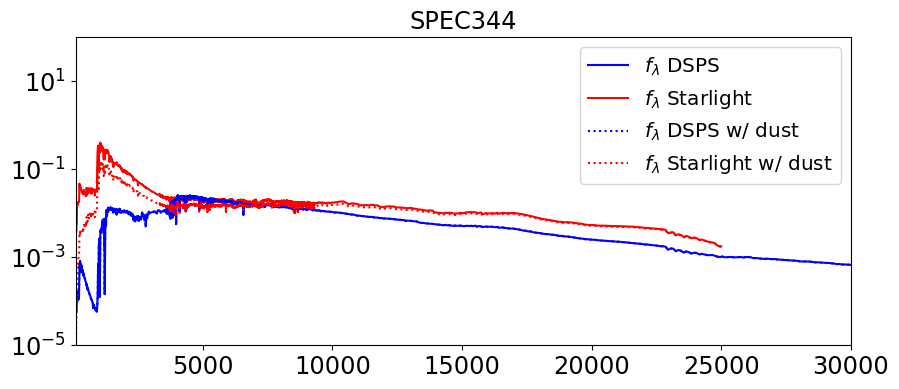

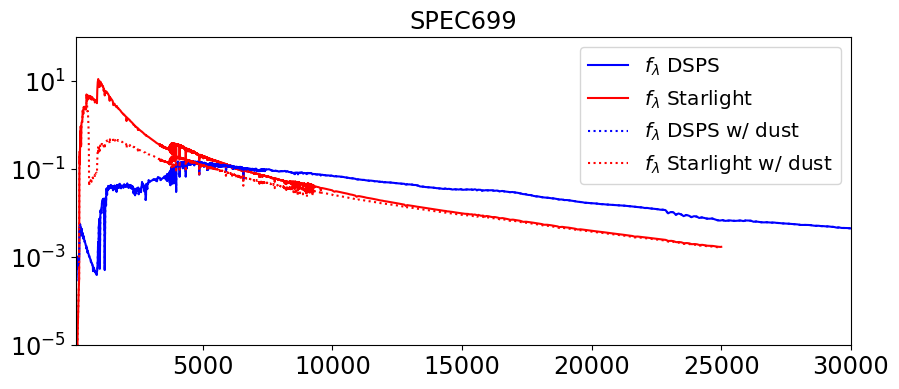

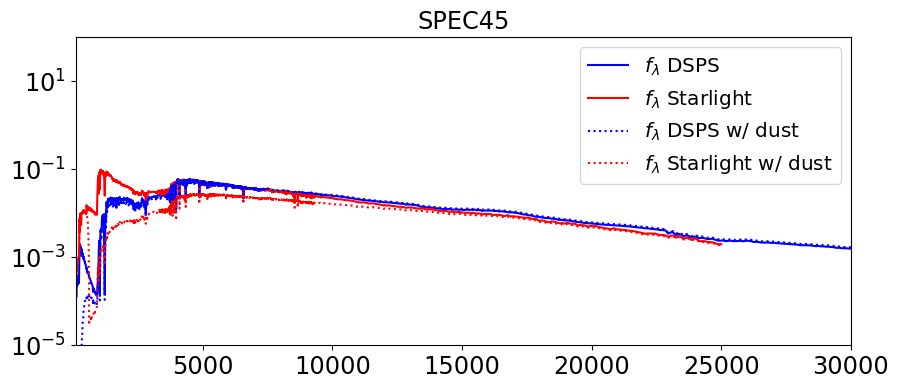

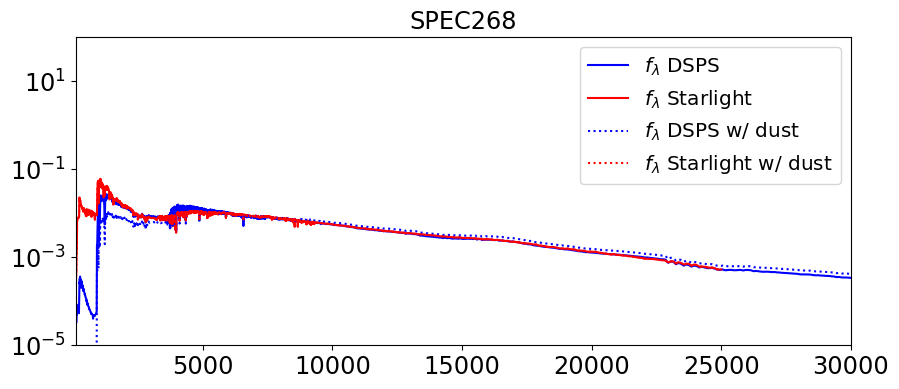

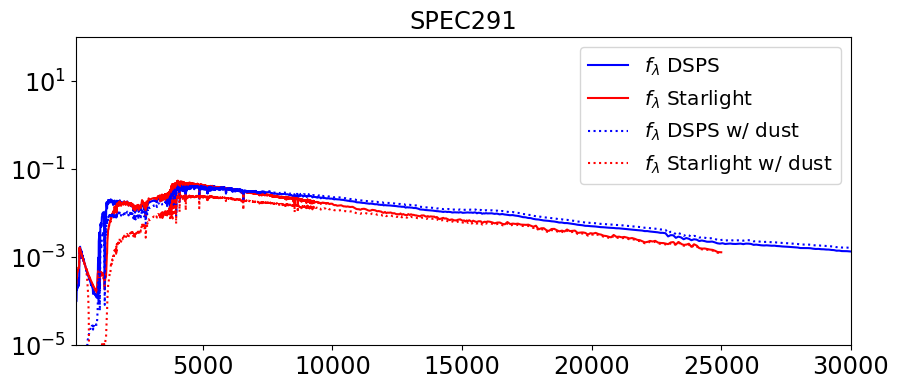

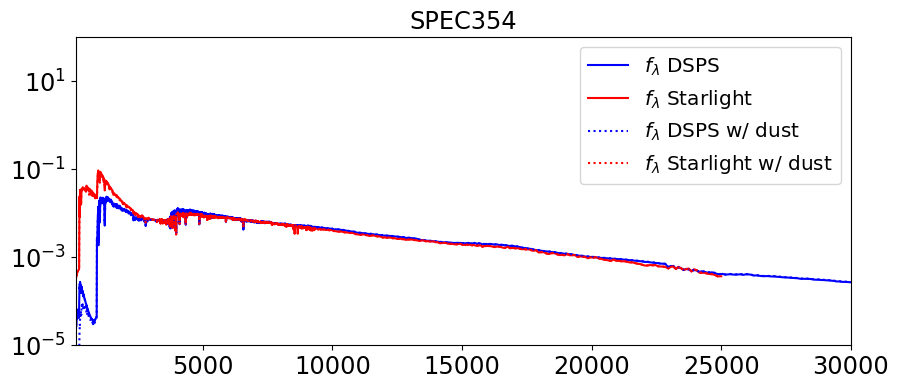

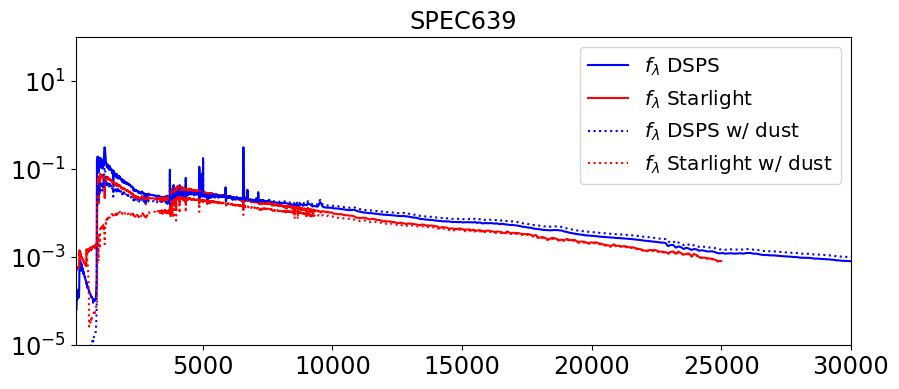

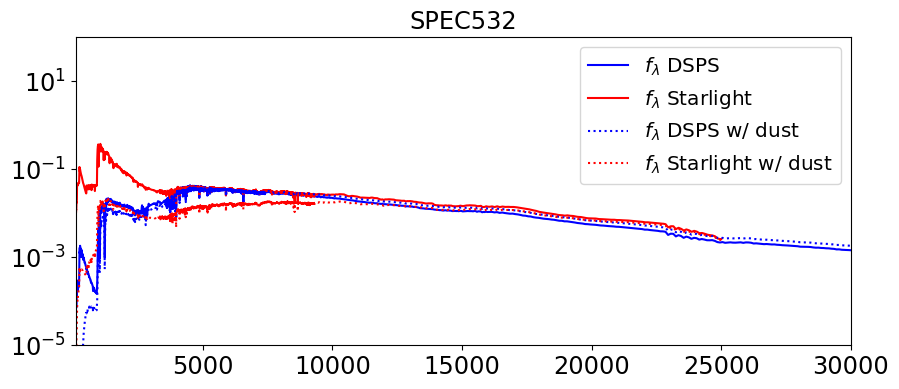

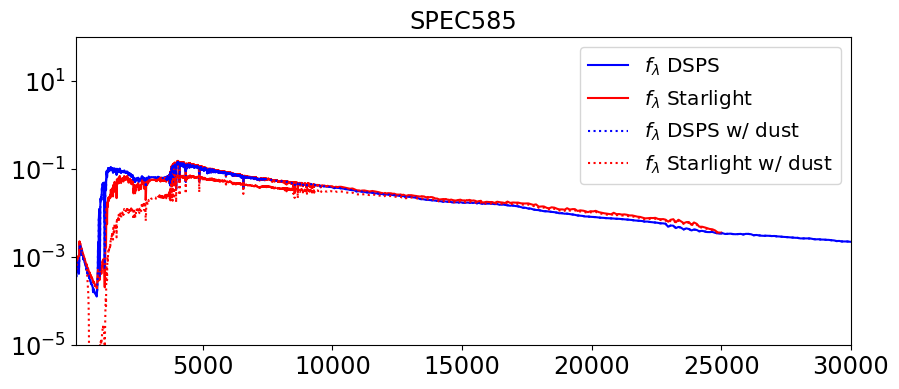

In [23]:
for templ_id in id_temp_fors2:
    groupname = f"SPEC{templ_id}"
    #print(groupname)
    try:
        group = hf.get(groupname)
        wl = np.array(group.get("wl"))
        fl = np.array(group.get("fl"))
        fl_dust = np.array(group.get("fl_dust"))
        fnu = np.array(group.get("fnu"))
        z = group.attrs.get("zobs")
        
        id_sum_df = np.where(summary_props["FORS2-SL Id"] == templ_id)[0][0]
        
        ebv = summary_props.loc[id_sum_df, "E(B-V)"] 
        
        wl_sl = df_sl_spec['Wavelength'].values
        fl_sl = df_sl_spec[f"SPEC_{templ_id}_HZ4_BC_EBV0_Z0"].values
        fldust_sl = df_sl_spec[f"SPEC_{templ_id}_HZ4_BC_EBV{ebv:.3f}_Z0"].values
        norm_sl = flux_norm(wl_sl, fl_sl)

        _, ax = plt.subplots(1, 1,figsize=(10,4))
        ax.plot(wl,fl*norm_sl,'b-', label="$f_\lambda$ DSPS")
        ax.plot(wl_sl, fl_sl, 'r-', label="$f_\lambda$ Starlight")
        ax.plot(wl,fl_dust*norm_sl,'b:', label="$f_\lambda$ DSPS w/ dust")
        ax.plot(wl_sl, fldust_sl, 'r:', label="$f_\lambda$ Starlight w/ dust")
        ax.set_yscale('log')
        #ax.set_xscale('log')
        ax.set_xlim(100.,3e4)
        ax.set_ylim(1e-5,100)
        ax.legend()
        ax.set_title(groupname)
    except AttributeError:
        print(templ_id)

In [24]:
#list_of_groupkeys

In [25]:
if os.getenv('LEPHAREDIR') is not None:
    LEPHAREDIR = os.getenv('LEPHAREDIR')
else:
    LEPHAREDIR = os.path.abspath(os.path.join(os.getcwd(), "LEPHARE"))
    os.environ['LEPHAREDIR'] = LEPHAREDIR
print(os.environ['LEPHAREDIR'])

lephare_res_dir = 'lephare_cosmos'
if os.getenv('LEPHAREWORK') is not None:
    LEPHAREWORK = os.environ['LEPHAREWORK']
else:
    LEPHAREWORK = os.path.abspath(os.path.join(os.getcwd(),lephare_res_dir))
    os.environ['LEPHAREWORK'] = LEPHAREWORK
print(os.environ['LEPHAREWORK'])

/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD/LEPHARE
/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD/lephare_cosmos


In [26]:
_gal_seds = 'FORS2_DSPS_batch1'
sed_dir = os.path.join(LEPHAREDIR, 'sed/GAL', _gal_seds)
if not os.path.isdir(sed_dir) : os.makedirs(sed_dir)
list_file_name = f'SED_FORS2_DSPS_noDust_v1'

In [27]:
if False:
    with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
        _l.write(f'# FORS2-derived templates selected and averaged regarding their type and E(B-V) value\n')
    for _col in df_dusty_templates.columns[1:]:
        _arr = np.column_stack((df_dusty_templates['Wavelength'], df_dusty_templates[_col]))
        np.savetxt(os.path.join(sed_dir,f'{_col}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
        with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
            _l.write(_gal_seds+f'/{_col}.sed\n')

In [28]:
if False:
    with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
        _l.write(f'# FORS2-derived templates selected and averaged regarding their type and E(B-V) value\n')
    for _col in df_EBV0_templates.columns[1:]:
        _arr = np.column_stack((df_EBV0_templates['Wavelength'], df_EBV0_templates[_col]))
        np.savetxt(os.path.join(sed_dir,f'{_col}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
        with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
            _l.write(_gal_seds+f'/{_col}.sed\n')

In [29]:
if False:
    with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
        _l.write(f'# FORS2-derived templates extrapolated using DSPS, without dust. Selection IAW previous list from Starlight templates. 304 omitted because absent from DSPS.\n')
    for templ_id in id_temp_fors2:
        groupname = f"SPEC{templ_id}"
        try:
            group = hf.get(groupname)
            wl = np.array(group.get("wl"))
            fl = np.array(group.get("fl"))
            
            wl_sl = df_sl_spec['Wavelength'].values
            fl_sl = df_sl_spec[f"SPEC_{templ_id}_HZ4_BC_EBV0_Z0"].values
            norm_sl = flux_norm(wl_sl, fl_sl)
            
            _arr = np.column_stack((wl, fl*norm_sl))
            np.savetxt(os.path.join(sed_dir,f'{groupname}_DSPS_noDust.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
            with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
                _l.write(_gal_seds+f'/{groupname}_DSPS_noDust.sed\n')
        except AttributeError:
            print(f"{groupname} not in DSPS results.")

In [30]:
sorted(os.listdir(sed_dir))

['SPEC107_DSPS_noDust.sed',
 'SPEC113_DSPS_noDust.sed',
 'SPEC114_DSPS_noDust.sed',
 'SPEC226_DSPS_noDust.sed',
 'SPEC227_DSPS_noDust.sed',
 'SPEC235_DSPS_noDust.sed',
 'SPEC265_DSPS_noDust.sed',
 'SPEC268_DSPS_noDust.sed',
 'SPEC282_DSPS_noDust.sed',
 'SPEC291_DSPS_noDust.sed',
 'SPEC344_DSPS_noDust.sed',
 'SPEC354_DSPS_noDust.sed',
 'SPEC451_DSPS_noDust.sed',
 'SPEC45_DSPS_noDust.sed',
 'SPEC496_DSPS_noDust.sed',
 'SPEC532_DSPS_noDust.sed',
 'SPEC537_DSPS_noDust.sed',
 'SPEC546_DSPS_noDust.sed',
 'SPEC585_DSPS_noDust.sed',
 'SPEC589_DSPS_noDust.sed',
 'SPEC639_DSPS_noDust.sed',
 'SPEC699_DSPS_noDust.sed',
 'SPEC714_DSPS_noDust.sed',
 'SPEC87_DSPS_noDust.sed']

## Plot all DSPS and all SL on the same plot

In [31]:
from EmuLP import Filter
_wls0 = np.arange(3600., 4300., 1.)
d4000n0_transm = np.zeros_like(_wls0)
d4000n0_transm[(_wls0>=3850.)*(_wls0<=3950.0)] = 1.0
d4000n0 = Filter.sedpyFilter(96, _wls0, d4000n0_transm)

d4000n1_transm = np.zeros_like(_wls0)
d4000n1_transm[(_wls0>=4000.)*(_wls0<=4100.0)] = 1.0
d4000n1 = Filter.sedpyFilter(97, _wls0, d4000n1_transm)

In [32]:
colNorm = colors.Normalize(vmin=0.95*min(summary_props['D4000n'].values), vmax=1.05*max(summary_props['D4000n'].values))

blues = plt.get_cmap('Blues')
bluMap = cmx.ScalarMappable(norm=colNorm, cmap=blues)
all_blues = bluMap.to_rgba(summary_props['D4000n'].values, alpha=1)

oranges = plt.get_cmap('Oranges')
oraMap = cmx.ScalarMappable(norm=colNorm, cmap=oranges)

SPEC110 not in DSPS results.
SPEC111 not in DSPS results.
SPEC112 not in DSPS results.
SPEC183 not in DSPS results.
SPEC274 not in DSPS results.
SPEC304 not in DSPS results.
SPEC339 not in DSPS results.
SPEC533 not in DSPS results.
SPEC550 not in DSPS results.


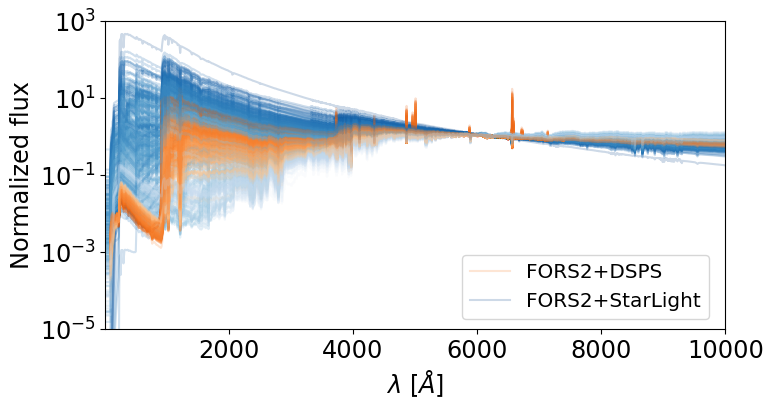

In [34]:
f,a = plt.subplots(1,1)
for ntp, templ_id in enumerate(summary_props['FORS2-SL Id'].values):
    groupname = f"SPEC{templ_id}"
    try:
        group = hf.get(groupname)
        wl = np.array(group.get("wl"))
        fl = np.array(group.get("fl"))
        fnu = np.array(group.get("fnu"))
        z = group.attrs.get("zobs")
        
        flux_d4000 = np.interp(_wls0, wl, fl)
        d4000n = np.trapz(flux_d4000*d4000n0.transmission, x=_wls0) / np.trapz(flux_d4000*d4000n1.transmission, x=_wls0)
        ora = oraMap.to_rgba(d4000n, alpha=1)
        
        wl_sl = df_sl_spec['Wavelength'].values
        fl_sl = df_sl_spec[f"SPEC_{templ_id}_HZ4_BC_EBV0_Z0"].values
        norm_sl = flux_norm(wl_sl, fl_sl)
        if summary_props.loc[ntp, 'D4000n'] == max(summary_props['D4000n'].values) :
            leg_dsps = "FORS2+DSPS"
            leg_SL = "FORS2+StarLight"
        else : 
            leg_dsps=leg_SL=""
        a.plot(wl, fl, c=ora, alpha=0.2, label=leg_dsps)
        a.plot(wl_sl, fl_sl/norm_sl, c=all_blues[ntp], alpha=0.2, label=leg_SL)
    except AttributeError:
        print(f"{groupname} not in DSPS results.")
a.set_yscale('log')
#a.set_xscale('log')
a.set_xlim(10.,1e4)
a.set_ylim(1e-5,1e3)
a.set_xlabel("$\lambda\ [\AA]$")
a.set_ylabel("Normalized flux")
a.legend(loc="lower right", bbox_to_anchor=(0.99, 0.0))